In [1]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch.distributions as D

from torch.distributions.multivariate_normal import MultivariateNormal
from scipy.linalg import expm
from sklearn.datasets import make_spd_matrix
from copy import deepcopy
from scipy.stats import multivariate_normal

sys.path.append("./lib")

from swgf_mynf import *
from nf.realnvp import *
from nf.utils_nf import log_likelihood
from nf.utils_plot_nf import *
from utils_plot import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Sliced-Wasserstein Gradient Flow with Generative Models

We focus on the Fokker-Planck PDE:

**Fokker-Planck Equation**:
- PDE:
\begin{equation}
    \frac{\partial\rho}{\partial t} = \mathrm{div}(\rho\nabla V)+\Delta \rho
\end{equation}
- Associated SDE:
\begin{equation*}
    \mathrm{d}x_t = \nabla V(x)\mathrm{d}t+\sqrt{2}\mathrm{d}w_t
\end{equation*}


**JKO Scheme in SW Space**:

We want to solve at each step:

\begin{equation*}
    \rho_{k+1}^\tau = \mathrm{argmin}_{\rho\in\Sigma_n}\ \frac{1}{2\tau}SW_2^2(\rho,\rho_k^\tau) + J(\rho).
\end{equation*}

Goal: model the distributions by a generative model $\hat{\rho}=(g_\theta)_\# p_Z$ with $p_Z$ some ``simple''distribution. Thus, the problem becomes
\begin{equation*}
    \theta_{k+1} \in\mathrm{argmin}_\theta\ \frac{1}{2\tau} SW_2^2((g_\theta)_\# p_Z,\rho_k^\tau)+J((g_\theta)_\# p_Z)
\end{equation*}
with
\begin{equation}
    \begin{aligned}
        J(\rho) &= \int V(x)\rho(x)\mathrm{d}x + \int \log(\rho(x))\rho(x)\mathrm{d}x \\
        &\approx \frac{1}{n}\sum_{i=1}^n V(x_i) + \frac{1}{n}\sum_{i=1}^n \log(\rho(x_i))
    \end{aligned}
\end{equation}
where $x_i=g_\theta(z_i)$, $z_i\sim p_Z$, and $\log\rho(x_i)=\log p_Z(z_i) - \log\det J_{g_\theta}(z_i)$, if $g_\theta$ is invertible (e.g. normalizing flow).


#### Gaussian cased with closed-form

\begin{equation*}
    \mathrm{d}X_t = -AX_t\mathrm{d}t+\sqrt{2}\mathrm{d}W_t
\end{equation*}
Here, $V(x)=\frac12 X^T A X$.
We will take $A=I$ and initialize with $\rho_0=\mathcal{N}(\mu_0,\Sigma_0)$ and $\mu_0=\begin{pmatrix}2 \\ 2 \end{pmatrix}$, $\Sigma_0 = 4 I_2$.

The analytical pdf at each time $t$ is $\mathcal{N}\Big(\exp(-At)\mu_0,(\Sigma_0-A^{-1})\exp(-2At)+A^{-1}\Big)$.

In [3]:
A = torch.tensor(np.eye(2),dtype=torch.float).to(device)

mu0 = torch.tensor(np.array([2,2]),device=device,dtype=torch.float)
sigma0 = torch.tensor(4*np.eye(2),device=device,dtype=torch.float)

A2 = A.detach().cpu().numpy()
mu02 = mu0.detach().cpu().numpy()
sigma02 = sigma0.detach().cpu().numpy()
A2_ = np.linalg.inv(A2)

def true_mu(t):
    B = expm(-A2*t)
    return B@mu02

def true_Sigma(t):
    e = expm(-2*A2*t)
    s = (sigma02-A2_)@e+A2_
    return s

mu_stationary = np.zeros(2)
sigma2_stationary = A2_

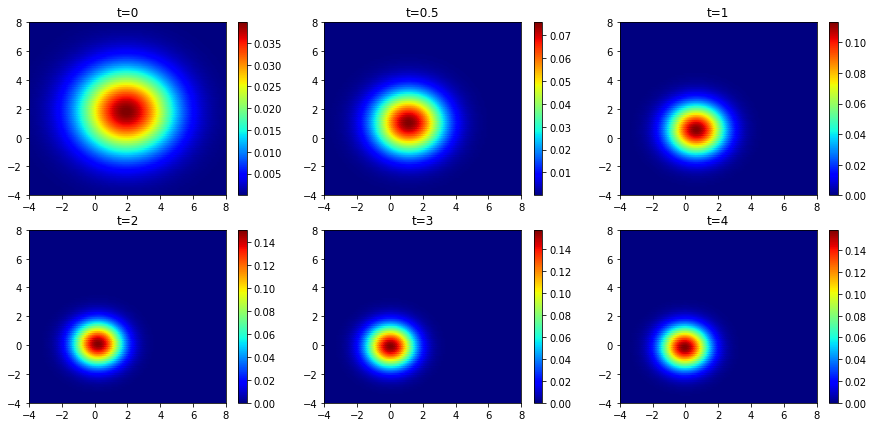

In [4]:
plot_true_density_gaussians(true_mu, true_Sigma, ts=[0,0.5,1,2,3,4])

In [5]:
def V(x):
    x = x[:,:,None]   
    y = torch.matmul(A,x)
    z = torch.matmul(torch.transpose(x,1,2),y)
    return z[:,0,0]/2

def J(x, z, log_det):
    h = torch.mean(log_likelihood(z, log_det, device),axis=0) ## entropy
    return torch.mean(V(x),axis=0)+h

In [6]:
beta = 1

t_init = 0
t_end = 4
h = 0.1

n_steps = int(np.ceil((t_end-t_init)/h))

d = 2
rho_0 = MultivariateNormal(mu0,sigma0)

lrs = 1e-3 * np.ones(n_steps)
lrs[0] = 5e-3

Lrho = SWGF(rho_0, h, n_step=n_steps, n_epochs=200, 
            J=J, create_NF=create_RealNVP, nh=64, nl=5, lrs=lrs, 
            num_projections=500, n_samples=1000, tqdm_bar=True)

Time: 6mn

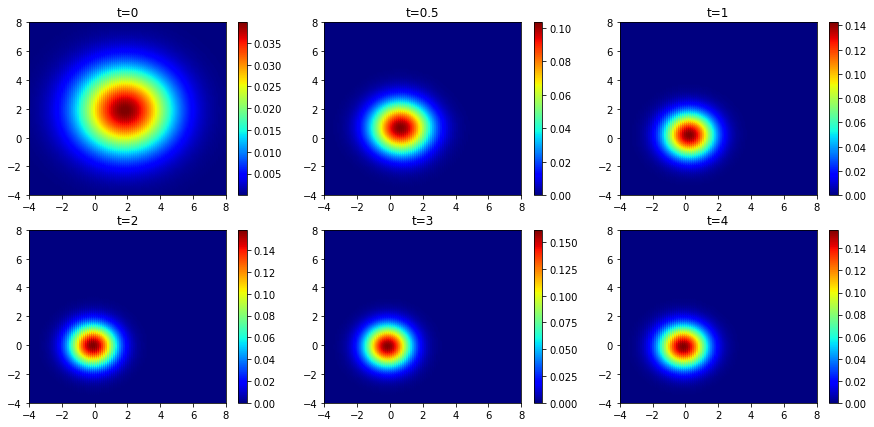

In [7]:
plot_density_ts(Lrho, device, ts=[0,0.5,1,2,3,4])

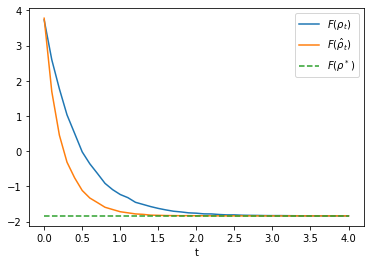

In [8]:
plot_F_gaussians(Lrho, J, V, true_mu, true_Sigma, mu_stationary, sigma2_stationary, device)

It seems that $\rho_{2t}=\hat{\rho}_t$.

Keep in mind that $\inf_{w\in AC_{\mu,\nu}(SW_p)}\ L_{SW_p}(w)=c_{d,p}W_p(\mu,\nu)$. And for $d=2$ and $p=2$, $c_{2,2}^2 = \frac12$.

$c_{d,p}^p = \frac{1}{d}\int_{S^{d-1}}\|\theta\|_p^p\lambda(\mathrm{d}\theta)$

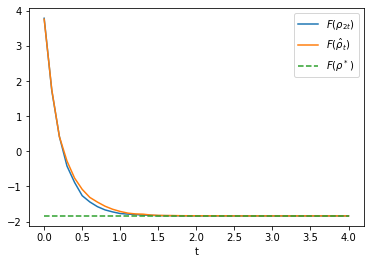

In [9]:
plot_F_gaussians(Lrho, J, V, true_mu, true_Sigma, mu_stationary, sigma2_stationary, device,
                 t_end=t_end, dilation=2)

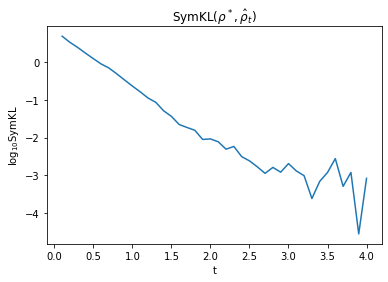

In [10]:
distr_stationary = D.MultivariateNormal(torch.tensor(mu_stationary, dtype=torch.float, device=device), 
                                        torch.tensor(sigma2_stationary, dtype=torch.float, device=device))

plot_SymKL(Lrho, distr_stationary, t_init, t_end, h, device, log10=True)

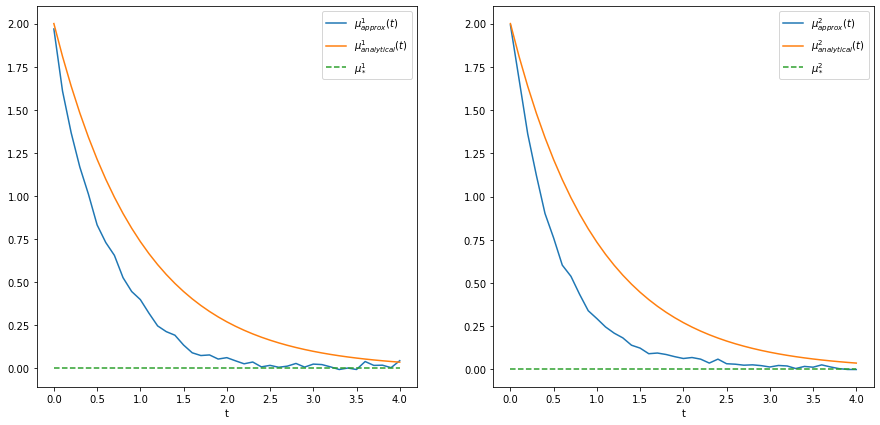

In [11]:
plot_mean(Lrho, true_mu, mu_stationary, t_init, t_end, device)

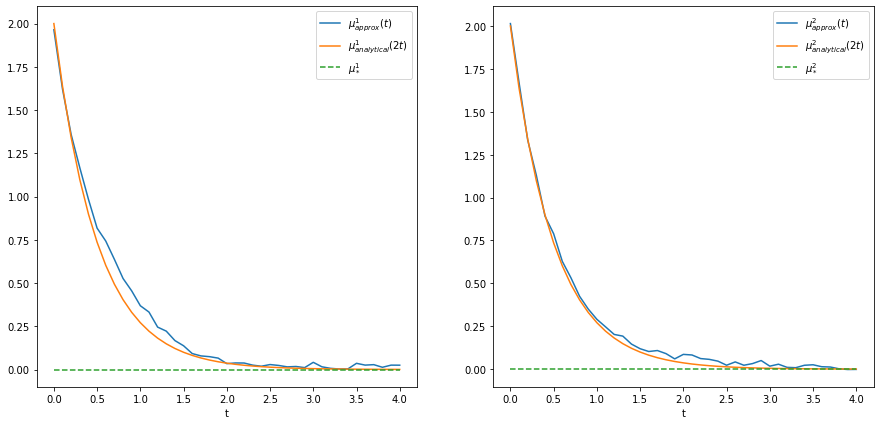

In [12]:
plot_mean(Lrho, true_mu, mu_stationary, t_init, t_end, device, dilation=2)

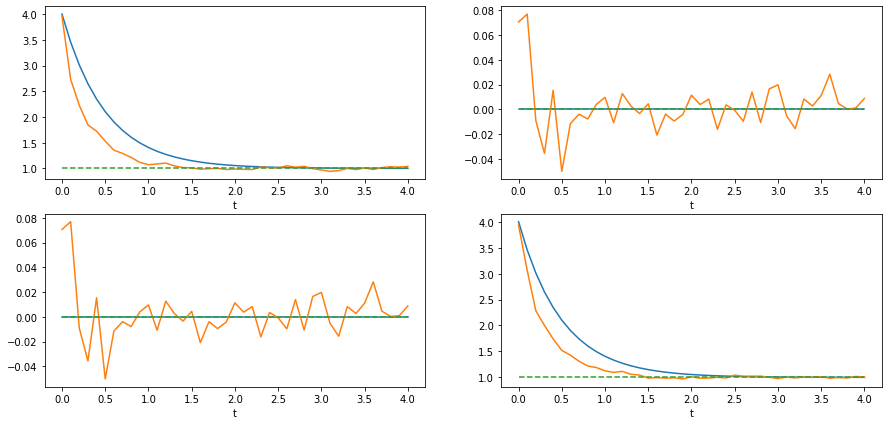

In [13]:
plot_var(Lrho, true_Sigma, sigma2_stationary, 0 ,4, device)

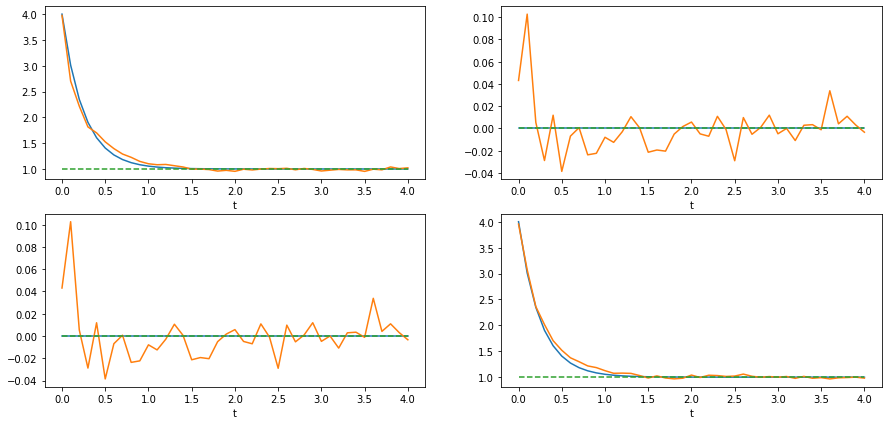

In [14]:
plot_var(Lrho, true_Sigma, sigma2_stationary, 0 ,4, device, dilation=2)

#### Gaussian more complicated

\begin{equation*}
    \mathrm{d}X_t = -\nabla V(X_t)\mathrm{d}t+\sqrt{2}\mathrm{d}W_t
\end{equation*}
Here, $V(x)=\frac12 (X-b)^T A (X-b)$.
We will take $A$ and $b$ randomly and initialize with $\rho_0=\mathcal{N}(\mu_0,\Sigma_0)$ and $\mu_0=0$, $\Sigma_0 = I_2$.

The analytical pdf at each time $t$ is $\mathcal{N}\Big(b+e^{-tA}(\mathbb{E}[X_0]-b),e^{-tA}\mathrm{Cov}(X_0)e^{-tA^T}+A^{-\frac12}(I-e^{-2tA})(A^{-\frac12})^T\Big)$.

In [42]:
random_state = 42
np.random.seed(random_state)

A2 = make_spd_matrix(2, random_state=random_state)
b2 = np.random.randn(2)

A = torch.tensor(A2, dtype=torch.float).to(device)
b = torch.tensor(b2, dtype=torch.float).to(device)

mu0 = torch.tensor(np.array([0,0]),device=device,dtype=torch.float)
sigma0 = torch.tensor(np.eye(2),device=device,dtype=torch.float)

A2 = A.detach().cpu().numpy()
mu02 = mu0.detach().cpu().numpy()
sigma02 = sigma0.detach().cpu().numpy()
A2_ = np.linalg.inv(A2)
# b2 = b.detach().cpu().numpy()

def true_mu(t):
    B = expm(-A2*t)
    return b2+B @(mu02-b2)

def true_Sigma(t):
    e = expm(-2*A2*t)
    B = expm(-t*A2)
    A12_ = sp.linalg.sqrtm(A2_)
    cpt1 = B@sigma02@B.T
    cpt2 = A12_@(np.eye(2)-e)@A12_.T
    return cpt1+cpt2

mu_stationary = b2
sigma2_stationary = A2_

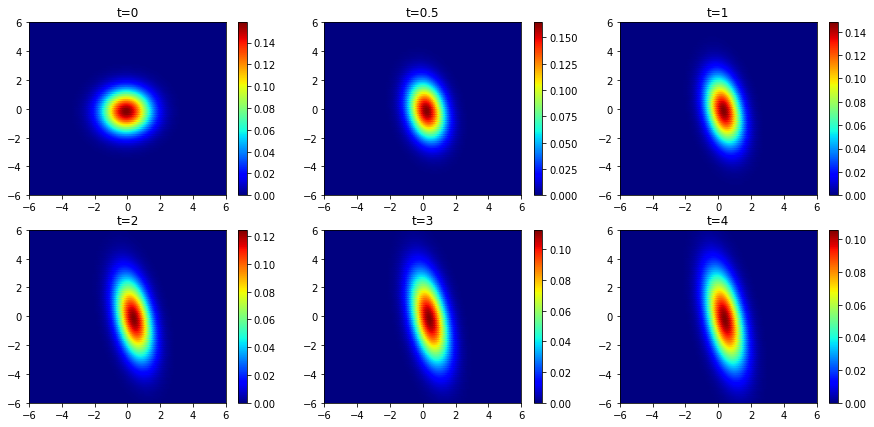

In [43]:
plot_true_density_gaussians(true_mu, true_Sigma, ts=[0,0.5,1,2,3,4], xmin=-6, xmax=6, ymin=-6, ymax=6)

In [44]:
print(A2,b2)

[[2.094176   0.34617642]
 [0.34617642 0.21783714]] [ 0.49671415 -0.1382643 ]


In [45]:
def V(x):
    x = x[:,:,None]
    y = torch.matmul(A,x-b[:,None])
    z = torch.matmul(torch.transpose(x-b[:,None],1,2),y)
    return z[:,0,0]/2

def J(x, z, log_det):
    h = torch.mean(log_likelihood(z, log_det, device),axis=0) ## entropy
    return torch.mean(V(x),axis=0)+h

In [46]:
t_init = 0
t_end = 4
h = 0.1

n_steps = int(np.ceil((t_end-t_init)/h))

d = 2
rho_0 = MultivariateNormal(mu0,sigma0)

lrs = np.ones(n_steps)*1e-4
lrs[:5] = 1e-3

Lrho = SWGF(rho_0, h, n_step=n_steps, n_epochs=400, 
            J=J, create_NF=create_RealNVP, nh=64, nl=5, lrs=lrs, 
            num_projections=200, n_samples=500, plot_loss=False)

Time: 12mn

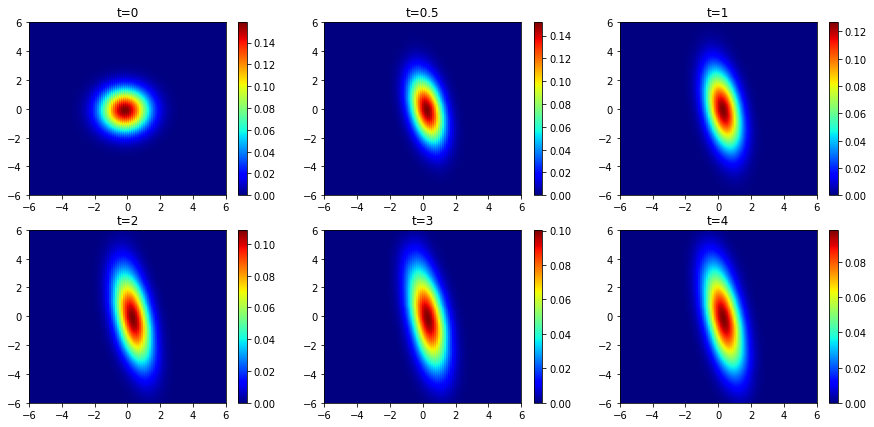

In [47]:
plot_density_ts(Lrho, device, ts=[0,0.5,1,2,3,4], xmin=-6, xmax=6, ymin=-6, ymax=6)

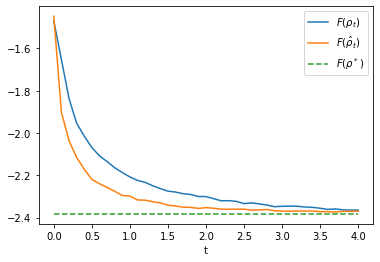

In [48]:
plot_F_gaussians(Lrho, J, V, true_mu, true_Sigma, mu_stationary, sigma2_stationary, device, n_samples=10000)

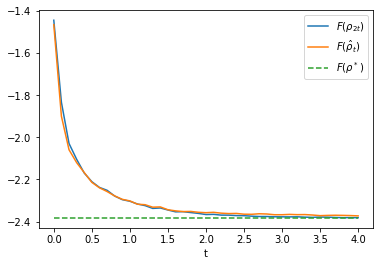

In [49]:
plot_F_gaussians(Lrho, J, V, true_mu, true_Sigma, mu_stationary, sigma2_stationary, device,
                 t_end=t_end, dilation=2, n_samples=10000)

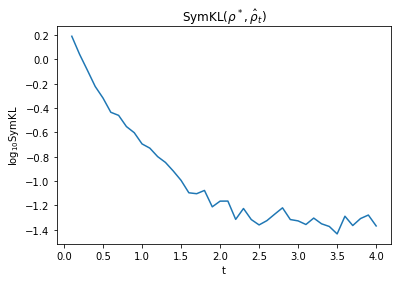

In [50]:
distr_stationary = D.MultivariateNormal(torch.tensor(mu_stationary, dtype=torch.float, device=device), 
                                        torch.tensor(sigma2_stationary, dtype=torch.float, device=device))

plot_SymKL(Lrho, distr_stationary,t_init, t_end, h, device, log10=True)

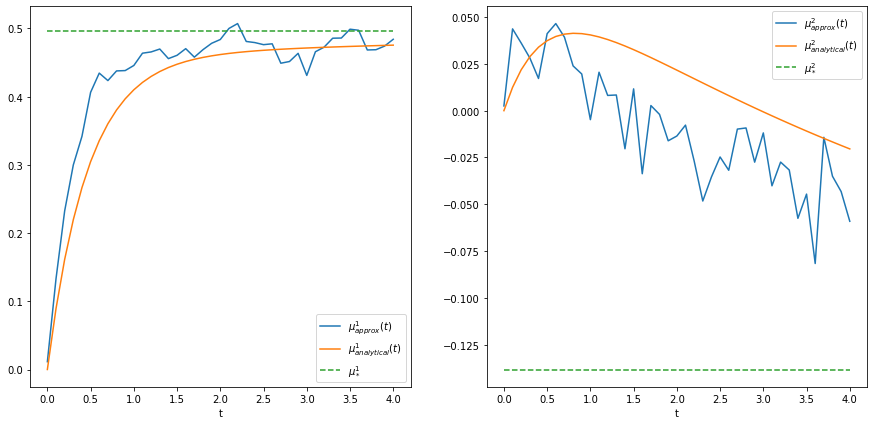

In [52]:
plot_mean(Lrho, true_mu, mu_stationary, t_init, t_end, device)

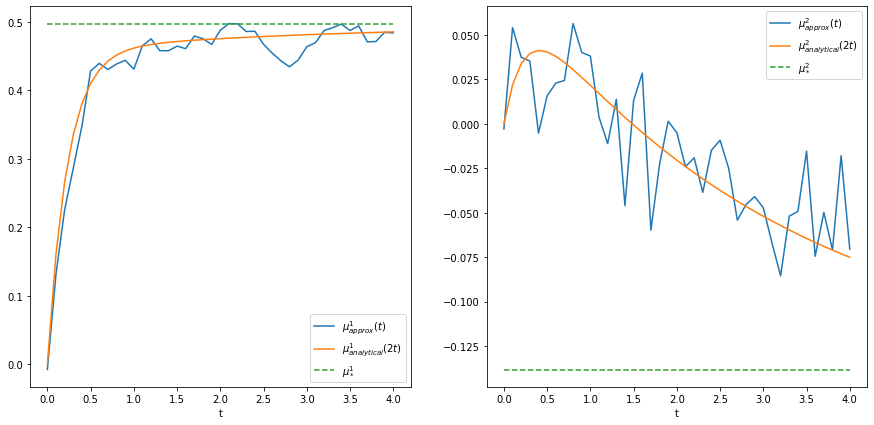

In [53]:
plot_mean(Lrho, true_mu, mu_stationary, t_init, t_end, device, dilation=2)

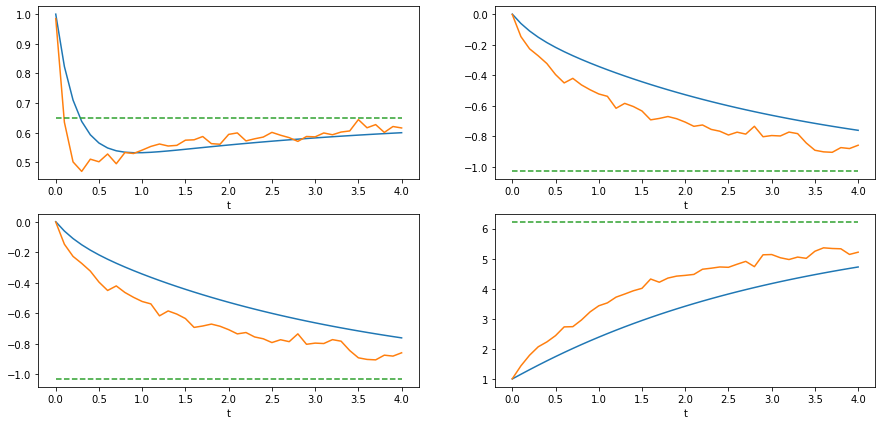

In [54]:
plot_var(Lrho, true_Sigma, sigma2_stationary, 0 ,4, device)

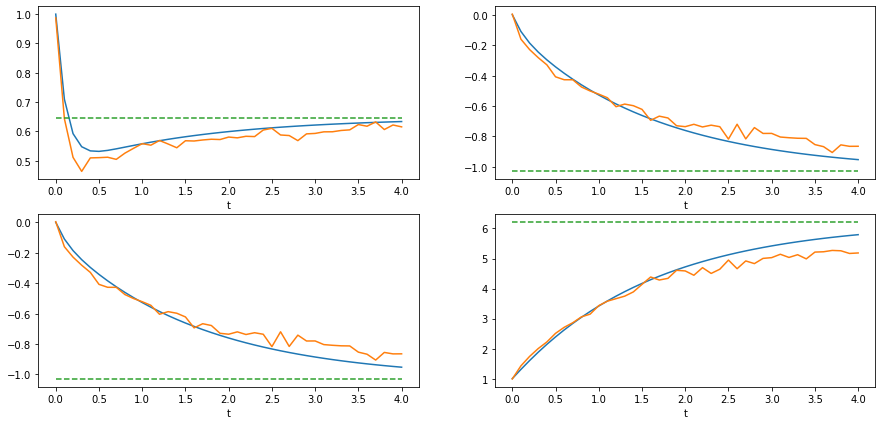

In [55]:
plot_var(Lrho, true_Sigma, sigma2_stationary, 0 ,4, device, dilation=2)

#### Gaussian Mixture

In [56]:
random_state = 42
torch.manual_seed(random_state)

d = 2
M = 5
l = 10

p = torch.ones(M)/M
mus = -l/2 + l * torch.rand((M,d), dtype=torch.float32, device=device)
sigmas = [torch.eye(d, device=device, dtype=torch.float32) for i in range(M)]

mix = D.Categorical(p.to(device))
comp = D.Independent(D.Normal(mus,torch.ones(M,2,device=device)),1)

gm = D.MixtureSameFamily(mix, comp)

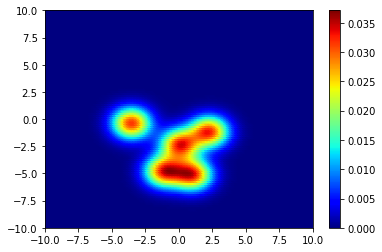

In [57]:
plot_true_density(gm, device, xmin=-10, xmax=10, ymin=-10, ymax=10)

In [58]:
def V(x):
    dists = -torch.square(torch.cdist(mus,x))/2
    return -torch.logsumexp(dists,0)

def J(x, z, log_det):
    h = log_likelihood(z, log_det, device) ## entropy
    v = V(x)
    
    if torch.any(torch.isnan(v)) or torch.any(torch.isnan(h)):
        print("?")
    if torch.any(torch.isinf(v)) or torch.any(torch.isinf(h)):
        print("??")
    
    return torch.mean(v+h,axis=0)

In [59]:
t_init = 0
t_end = 4
h = 0.1

n_steps = int(np.ceil((t_end-t_init)/h))

d = 2
rho_0 = MultivariateNormal(mu0,16*sigma0)

lrs = np.ones(n_steps)*1e-4
lrs[:5] = 1e-3

Lrho = SWGF(rho_0, h, n_step=n_steps, n_epochs=500, 
            J=J, create_NF=create_RealNVP, nh=64, nl=5, lrs=lrs, 
            num_projections=200, n_samples=512, plot_loss=False)

Time: 16mn

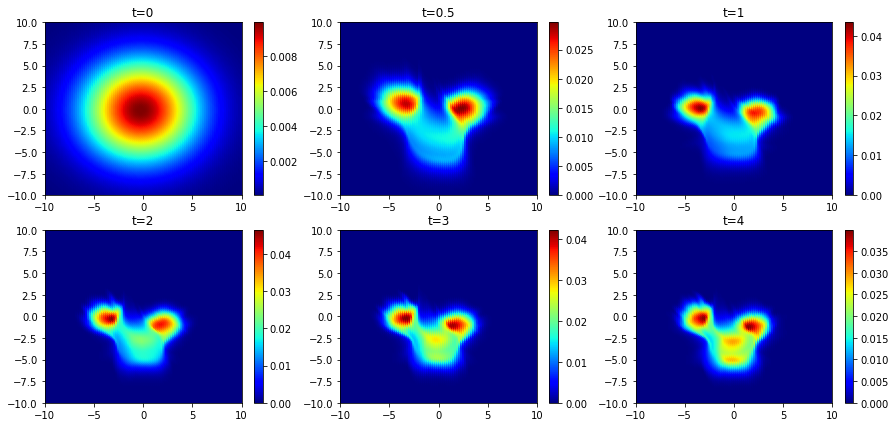

In [60]:
plot_density_ts(Lrho, device, ts=[0,0.5,1,2,3,4], xmin=-10, xmax=10, ymin=-10, ymax=10)

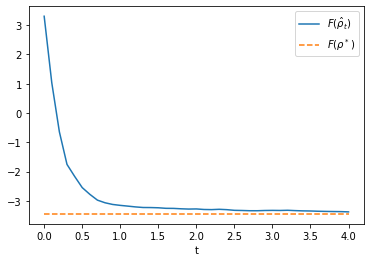

In [61]:
plot_F(Lrho, J, V, device, gm)

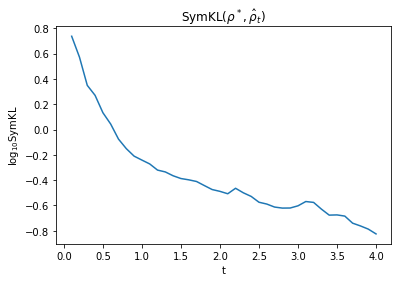

In [62]:
plot_SymKL(Lrho, gm, t_init, t_end, h, device, log10=True)